Library Importing

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
torch.cuda.manual_seed_all
%matplotlib inline

import torch
from torchvision import datasets
import torchvision.transforms as transforms

 Loading train and test data. Splitting the training set into training and validation.

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

validation_size = int(0.05*len(train_data))
training_size = int(0.95*len(train_data))

train_dataset, validation_dataset = torch.utils.data.random_split(train_data, [training_size, validation_size])

0it [00:00, ?it/s]

9920512it [00:01, 8549453.53it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130738.85it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2131221.87it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 50141.54it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Load Data

In [0]:
batch_size = 20
epochs = 8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

Encoder & Decoder in Different Modules with bottleneck value passed in

In [0]:
class Encoder(nn.Module):

   def __init__(self,bottleneck):
     super().__init__()
     self.conv1 = nn.Conv2d(1,16,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(16,4,3,padding=1)
     self.flat  = nn.Flatten()
     self.botl  = nn.Linear(7*7*4,bottleneck) 

   def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        x = self.flat(x)
        x = self.botl(x)
        return x

class Decoder(nn.Module):

   def __init__(self,bottleneck):
     super().__init__()

     self.botle2 =  nn.Linear(bottleneck,4*7*7)
     self.conv1_t = nn.ConvTranspose2d(4,16, 2, stride=2)
     self.conv2_t = nn.ConvTranspose2d(16, 1, 2, stride=2)
       

   def forward(self,x):
     x = self.botle2(x)
     x = x.view(-1,4,7,7)
     x = F.relu(self.conv1_t(x))
     x = F.sigmoid(self.conv2_t(x))
      
     return x

class Concatenator(nn.Module):

  def __init__(self, enc, dec):
    super().__init__()

    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    x = self.encoder(x)
    y = self.decoder(x)

    return y



Training function              

In [0]:
def train_model_ex1(model, criterion, train_loader,validation_loader, epochs):
  
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_losses, validation_losses, validation_x_value = [], [], []
  i = 0
  

  for e in range(1, epochs+1):
        train_loss = 0.0 
        validation_loss = 0.0 
         
        model.train()

        for data in train_loader:
           
            images, _ = data                        
            optimizer.zero_grad()     
            outputs = model(images)    
            loss = criterion(outputs, images)
            loss.backward()  
            optimizer.step()           

            train_loss = loss.item()*images.size(0)
            train_losses.append(train_loss)
            i = i + 1

        for data in validation_loader:
           model.eval()
           images, _ = data                        
           outputs = model(images)                  
           loss = criterion(outputs, images)       
           validation_loss += loss.item()*images.size(0)
           
        
        validation_loss = validation_loss/len(validation_loader)

        validation_losses.append(validation_loss)
        validation_x_value.append(i)
        
  return train_losses, validation_losses, validation_x_value

Pass values and models with different bottlenecks to training and validation


In [6]:

criterion = nn.MSELoss()

enc1 =Encoder(20)
dec1 = Decoder(20)
model1 = Concatenator(enc1,dec1)

train_losses1, val_losses1, x_value = train_model_ex1(model1, criterion,train_loader,validation_loader,epochs)


enc2  =Encoder(40)
dec2 = Decoder(40)
model2 = Concatenator(enc2,dec2)
train_losses2, val_losses2, x_value = train_model_ex1(model2,criterion,train_loader,validation_loader,epochs)


enc3 =Encoder(80)
dec3 = Decoder(80)
model3 = Concatenator(enc3,dec3)
train_losses3, val_losses3, x_value = train_model_ex1(model3,criterion,train_loader,validation_loader,epochs)


enc4 =Encoder(120)
dec4 = Decoder(120)
model4 = Concatenator(enc4,dec4)
train_losses4, val_losses4, x_value = train_model_ex1(model4,criterion,train_loader,validation_loader,epochs)







/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Plot losses for models with different bottlenecks

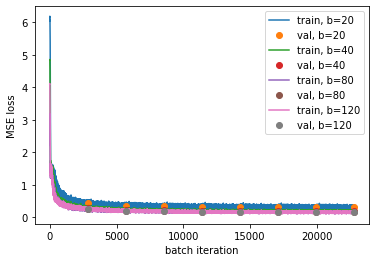

In [7]:
import matplotlib.pyplot as plt

plt.ylabel('MSE loss')
plt.xlabel('batch iteration')

plt.plot(train_losses1, label='train, b=20')
plt.plot(x_value, val_losses1, 'o', label='val, b=20')

plt.plot(train_losses2, label='train, b=40')
plt.plot(x_value, val_losses2, 'o', label='val, b=40')

plt.plot(train_losses3, label='train, b=80')
plt.plot(x_value, val_losses3, 'o', label='val, b=80')

plt.plot(train_losses4, label='train, b=120')
plt.plot(x_value, val_losses4, 'o', label='val, b=120')


plt.legend()

Function that computes train and validation MSE loss and number of params     

In [0]:
def test_model(model, criterion, test_loader,validation_loader, epochs, bottleneck):
 
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  model.eval()

  test_loss=0.0
  val_loss = 0.0

  for data in test_loader:
    images, _ = data                        
    outputs = model(images)                  
    loss = criterion(outputs, images)       
    test_loss += loss.item()*images.size(0)

  for data in validation_loader:
    images, _ = data                        
    outputs = model(images)                  
    loss = criterion(outputs, images)       
    val_loss += loss.item()*images.size(0)
          
  test_loss = test_loss/len(test_loader)
  val_loss = val_loss/len(validation_loader)
  
  total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


  print('Bottleneck: {:.1f}'.format(bottleneck),
                '\tTest loss: {:.10f}'.format(test_loss),
                '\tValidation loss: {:.10f}'.format(val_loss),
                '\tNumber of params : {:.10f}'.format(total_params))

Pass values to function that compute losses and number of params for different models

In [9]:
criterion = nn.MSELoss()

test_model(model1,criterion,test_loader,validation_loader,epochs,20)
test_model(model2,criterion,test_loader,validation_loader,epochs,40)
test_model(model3,criterion,test_loader,validation_loader,epochs,80)
test_model(model4,criterion,test_loader,validation_loader,epochs,120)




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Bottleneck: 20.0 	Test loss: 0.2976270218 	Validation loss: 0.3085727546 	Number of params : 9133.0000000000
Bottleneck: 40.0 	Test loss: 0.1751365711 	Validation loss: 0.1833803030 	Number of params : 16993.0000000000
Bottleneck: 80.0 	Test loss: 0.1539589466 	Validation loss: 0.1598829415 	Number of params : 32713.0000000000
Bottleneck: 120.0 	Test loss: 0.1490536113 	Validation loss: 0.1558107230 	Number of params : 48433.0000000000


Selects one autoencoder (where bottleneck = 120) and send 5 random images from test set to that encoder. Shows the originial images with the reconstructed ones.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


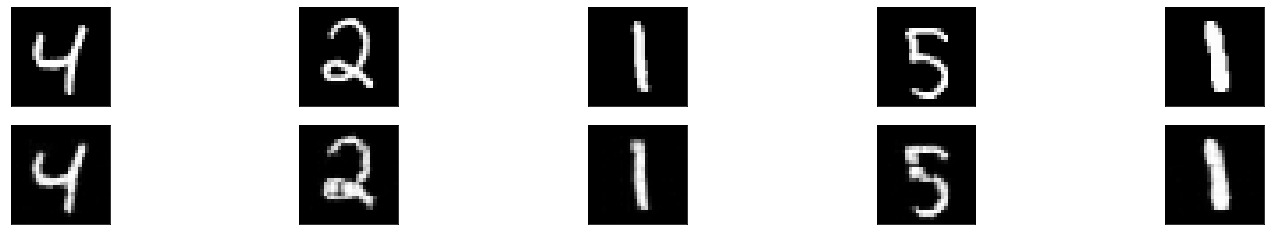

In [10]:

dataiter = iter(test_loader)

images, labels = dataiter.next()

output = model4(images)                     
images = images.numpy() 
  
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()           

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


Generate 5 new images by injecting random values as input to the decoder. 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


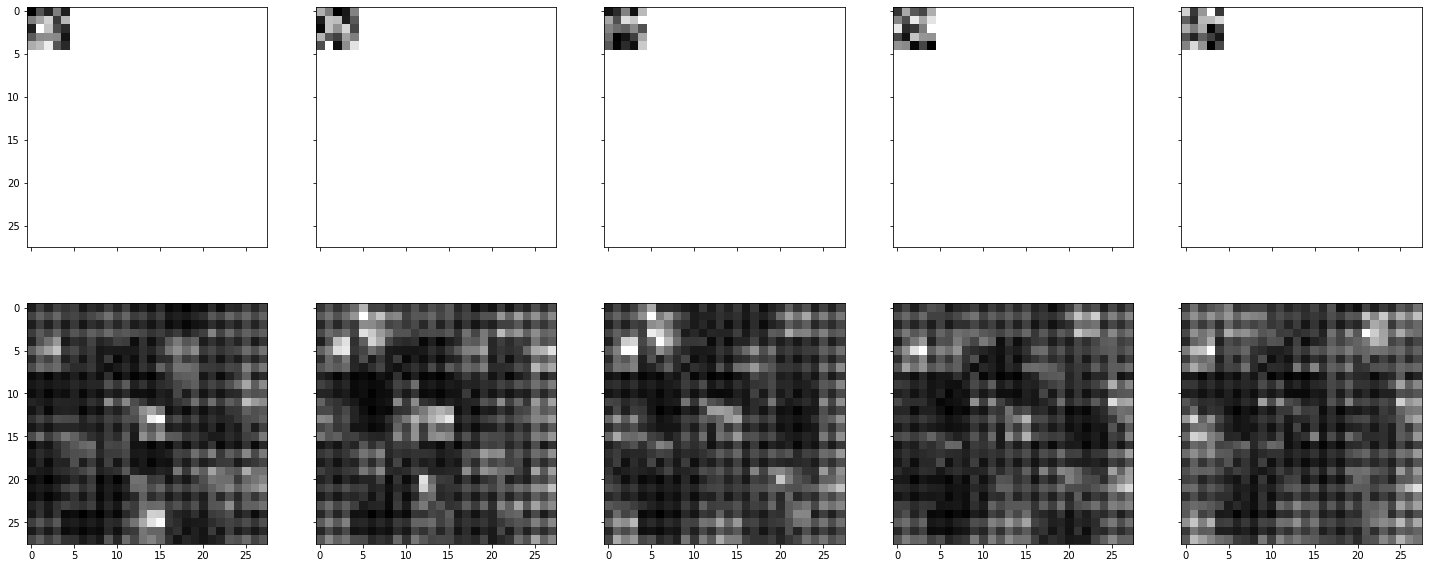

In [11]:
input = torch.rand(5,1,120)

new_dec = model4.decoder
output = new_dec(input.view(-1,1,120))

import cv2

from skimage import color
from skimage import io
input = input.view(-1,5,5,3)
output = output.view(-1,28,28)

input_new = input.detach().numpy()
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,10))
for i in range(5):
  
  axes[0][i].imshow(color.rgb2gray(input_new[i]),cmap = 'gray')
  axes[1][i].imshow(np.squeeze(output[i]),cmap = 'gray')



fig.show()

## **Excercise** 2


Classification model that takes in a encoder and add a fully connected layer

In [0]:
class classification_model(nn.Module):
  def __init__(self, encoder,bottleneck):
    super().__init__()
    self.encoder = encoder
    self.fully_connected = nn.Sequential(
      nn.Linear(bottleneck,10),
      nn.LogSoftmax(-1)
    )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fully_connected(x)
    return x

Select subset of 100 images & labels

In [0]:
subset  = torch.utils.data.Subset(train_dataset, range(0, 100))
subset_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size)

Train function

In [0]:
def train_model_ex2(model, optimizer, loader, epochs):
  criterion = F.nll_loss
  model.train()
  for e in range(1, epochs+1):
      for data in loader:   
        images, labels = data                       
        optimizer.zero_grad()                      
        outputs = model(images)            
        loss = criterion(outputs, labels)           
        loss.backward()                             
        optimizer.step() 

Get the previous used encoder (bottleneck = 120) weights and train that model

In [0]:
encoder = model4.encoder
bottleneck = 120

model_pretrain = classification_model(encoder, bottleneck)
optimizer = torch.optim.RMSprop(model_pretrain.parameters(), lr=0.001)


train_model_ex2(model_pretrain, optimizer, subset_loader, epochs)

Fine tuning training, using different learnig rates for different parts of classifier

In [0]:
model_finetune = classification_model(encoder, bottleneck)
optimizer = torch.optim.RMSprop([{'params': model_finetune.encoder.parameters(), "lr": 0.00000001},
                           {'params': model_finetune.fully_connected.parameters(), "lr": 0.001}])

train_model_ex2(model_finetune, optimizer, subset_loader, epochs)

Create new autoencoder with bottleneck 120 and train it from scratch.

In [0]:
new_encoder = Encoder(bottleneck)

model_new = classification_model(new_encoder, bottleneck)
optimizer = torch.optim.RMSprop(model_new.parameters(), lr=0.001)


train_model_ex2(model_new, optimizer, subset_loader, epochs)


Function that computes if prediction is correct or not




In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True)
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

Function for test

In [0]:
def test_epoch(test_loader, model, string_model):
    criterion = F.nll_loss
    model.eval()
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data in test_loader:
            data, labels = data
            output = model(data)
            test_loss += criterion(output, labels)
            acc += correct_predictions(output, labels)
    test_acc = 100. * acc / len(test_loader.dataset)

    print('Model: {}'.format(string_model),
                '\tTest accuracy: {:.4f}'.format(test_acc))
                
    

In [34]:
test_epoch(test_loader,model_pretrain,'pre-trained') 
test_epoch(test_loader,model_finetune,'finetune')
test_epoch(test_loader,model_new,'from scratch')



Model: pre-trained 	Test accuracy: 75.9900
Model: finetune 	Test accuracy: 73.8400
Model: from scratch 	Test accuracy: 73.8200
